In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.utils import shuffle
from tensorflow.keras.utils import plot_model
tfpl=tfp.layers
tfd=tfp.distributions
import matplotlib.pyplot as plt
import keras.backend as K
# ----------------------------------------------------
import skimage
import skimage.feature
import skimage.viewer
from skimage import color
from skimage.filters import sobel
from skimage import exposure
from skimage.filters import gaussian
from skimage.transform import rotate, rescale
from skimage import img_as_float
from skimage import filters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Viewer requires Qt


In [ ]:
def Guass(img):
  return gaussian(img, multichannel=True)
DATA=[]
for label,folder in enumerate(os.listdir('/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/capsnet-keras/Original')):
  for file in os.listdir(f'/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/capsnet-keras/Original/{folder}'):
    img=cv2.imread(f'/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/capsnet-keras/Original/{folder}/{file}')
    img=cv2.resize(img,(128,128))
    DATA.append((Guass(img/255.0),label))
DATA=np.array(DATA)
DATA=shuffle(DATA)
IMAGES=np.array([ i for i in DATA[:,0]]).reshape(3256,128,128,3)
LABELS=DATA[:,1]
x_train,x_test=IMAGES[:2500],IMAGES[2500:]
y_train,y_test=LABELS[:2500],LABELS[2500:]
x_train.shape,x_test.shape,y_train.shape,y_test.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


((2500, 128, 128, 3), (756, 128, 128, 3), (2500,), (756,))

In [ ]:
TRAINLABEL_FRAME=pd.DataFrame({
    'y_train':y_train
})
TESTLABEL_FRAME=pd.DataFrame({
    'y_test':y_test
})
TESTLABEL_FRAME.head()

,y_test
0,2
1,3
2,3
3,3
4,2


In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
u=enc.fit_transform(np.array(TRAINLABEL_FRAME['y_train']).reshape(-1,1)).toarray()
TRAINLABEL_FRAME[[ f'{i.split("_")[1]}/{j}' for i,j in zip(enc.get_feature_names(),['Benign','Early','Pre','Pro'])]]=u
TRAINLABEL_FRAME.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,y_train,0/Benign,1/Early,2/Pre,3/Pro
0,0,1.0,0.0,0.0,0.0
1,1,0.0,1.0,0.0,0.0
2,1,0.0,1.0,0.0,0.0
3,1,0.0,1.0,0.0,0.0
4,2,0.0,0.0,1.0,0.0


In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
u=enc.fit_transform(np.array(TESTLABEL_FRAME['y_test']).reshape(-1,1)).toarray()
TESTLABEL_FRAME[[ f'{i.split("_")[1]}/{j}' for i,j in zip(enc.get_feature_names(),['Benign','Early','Pre','Pro'])]]=u
TESTLABEL_FRAME.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,y_test,0/Benign,1/Early,2/Pre,3/Pro
0,2,0.0,0.0,1.0,0.0
1,3,0.0,0.0,0.0,1.0
2,3,0.0,0.0,0.0,1.0
3,3,0.0,0.0,0.0,1.0
4,2,0.0,0.0,1.0,0.0


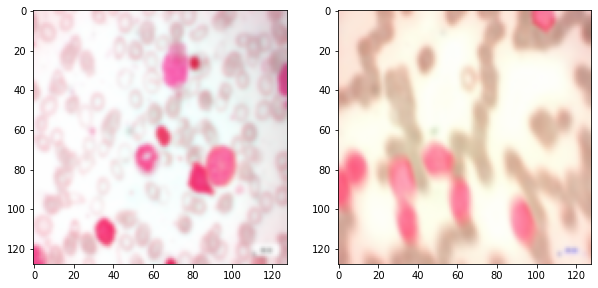

In [ ]:
plt.rcParams['figure.figsize']=(10,5)
plt.subplot(1,2,1)
plt.imshow(IMAGES[0])
plt.subplot(1,2,2)
plt.imshow(IMAGES[1])
plt.show()

## Model

In [ ]:
Data_augmentation = tf.keras.Sequential([
  keras.layers.Input(shape=(128,128,3)),
  keras.layers.RandomFlip("horizontal_and_vertical"),
  keras.layers.RandomRotation(0.2),
  keras.layers.RandomTranslation(height_factor=(-0.2,0.3),width_factor=(-0.2,0.3),fill_mode="reflect",
    interpolation="bilinear"),
  keras.layers.RandomZoom(height_factor=(0.2,0.3),width_factor=(0.2,0.3)),
  keras.layers.RandomHeight(0.2, interpolation="bilinear"),
  keras.layers.RandomContrast(0.25)
  ])

Exact_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, 
                                                          p) / 2600
def approximate_kl(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))
Approx_divergence_fn = lambda q, p, q_tensor : approximate_kl(q, p, 
                                                      q_tensor) / 2600
def PROBABILISTIC_CONV_LAYER(filters,size):
  return tfp.layers.Convolution2DReparameterization(filters, size,padding='same',activation='relu',
          kernel_prior_fn=tfpl.default_multivariate_normal_fn,
          kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
          kernel_divergence_fn=Approx_divergence_fn,
          bias_prior_fn=tfpl.default_multivariate_normal_fn,
          bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
          bias_divergence_fn=Approx_divergence_fn)

# def PROBABILISTIC_CONV_LAYER(filters,size):
#   return keras.layers.Conv2D(filters,size,activation='relu',padding='same')

def Hyper_Residuary_Bloc(inp, n_filters):
   a = PROBABILISTIC_CONV_LAYER(n_filters,(1,1))(inp)
   b= PROBABILISTIC_CONV_LAYER(n_filters,(3,3))(a)
   c= PROBABILISTIC_CONV_LAYER(n_filters,(5,5))(a)
   concat=keras.layers.concatenate([a,b,c])
   x = PROBABILISTIC_CONV_LAYER(1,(3,3))(keras.layers.concatenate([concat,c,a]))
   return x

def Complex_Incept_Block(layer_in, f1, f2,f3):
	conv1 = PROBABILISTIC_CONV_LAYER(f1,(1,1))(layer_in)
	conv3 = PROBABILISTIC_CONV_LAYER(f2,(3,3))(layer_in)
	conv5 = PROBABILISTIC_CONV_LAYER(f3,(5,5))(layer_in)
	pool = keras.layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	layer_out = keras.layers.concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out
tfd=tfp.distributions
tfpl=tfp.layers

def spike_and_slab(event_shape, dtype):
    distribution = tfd.Mixture(
        cat=tfd.Categorical(probs=[0.5, 0.5]),
        components=[
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=1.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1),
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=10.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1)],
    name='spike_and_slab')
    return distribution

def get_prior(kernel_size, bias_size, dtype=None):
    n = kernel_size+bias_size  
    prior_model = keras.models.Sequential([tfpl.DistributionLambda(lambda t : spike_and_slab(n, dtype))])
    return prior_model
def get_posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return keras.models.Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
        tfpl.IndependentNormal(n)
    ])

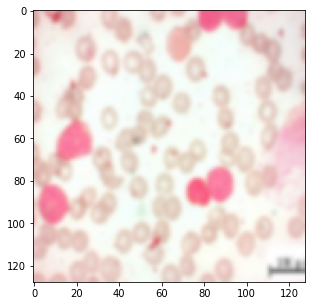

In [ ]:
plt.imshow(Data_augmentation(x_train)[100])

In [ ]:
INPUT=keras.layers.Input(shape=(128,128,3))
AUG_1=keras.layers.RandomFlip("horizontal_and_vertical")(INPUT)
AUG_2=keras.layers.RandomRotation(0.2)(AUG_1)
AUG_3=keras.layers.RandomContrast(0.2)(AUG_2)
Res_Block_1=Hyper_Residuary_Bloc(AUG_3,8)

dense_Network_1=tfp.layers.DenseReparameterization(
      units=tfp.layers.OneHotCategorical.params_size(4), activation=None,
      kernel_prior_fn = tfp.layers.default_multivariate_normal_fn,
      kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
      kernel_divergence_fn = Approx_divergence_fn,
      bias_prior_fn = tfp.layers.default_multivariate_normal_fn,
      bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
      bias_divergence_fn = Approx_divergence_fn)(keras.layers.Flatten()(Res_Block_1))
output_1=tfp.layers.OneHotCategorical(4)(dense_Network_1)

Res_Block_2_a=Hyper_Residuary_Bloc(Res_Block_1,8)
Res_Block_2_b=Hyper_Residuary_Bloc(Res_Block_1,8)

CONCAT_1=keras.layers.concatenate([Res_Block_2_a,Res_Block_2_b])
dense_Network_2=tfp.layers.DenseReparameterization(
      units=tfp.layers.OneHotCategorical.params_size(4), activation=None,
      kernel_prior_fn = tfp.layers.default_multivariate_normal_fn,
      kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
      kernel_divergence_fn = Approx_divergence_fn,
      bias_prior_fn = tfp.layers.default_multivariate_normal_fn,
      bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
      bias_divergence_fn = Approx_divergence_fn)(keras.layers.Flatten()(CONCAT_1))
output_2=tfp.layers.OneHotCategorical(4)(dense_Network_2)

Res_Block_3_a=Hyper_Residuary_Bloc(Res_Block_2_a,8)
Res_Block_3_b=Hyper_Residuary_Bloc(Res_Block_2_a,8)
Res_Block_3_c=Hyper_Residuary_Bloc(Res_Block_2_b,8)
Res_Block_3_d=Hyper_Residuary_Bloc(Res_Block_2_b,8)

CONCAT_2=keras.layers.concatenate([Res_Block_3_a,Res_Block_3_b,Res_Block_3_c,Res_Block_3_d])
dense_Network_3=tfp.layers.DenseReparameterization(
      units=tfp.layers.OneHotCategorical.params_size(4), activation=None,
      kernel_prior_fn = tfp.layers.default_multivariate_normal_fn,
      kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
      kernel_divergence_fn = Approx_divergence_fn,
      bias_prior_fn = tfp.layers.default_multivariate_normal_fn,
      bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
      bias_divergence_fn = Approx_divergence_fn)(keras.layers.Flatten()(CONCAT_2))
output_3=tfp.layers.OneHotCategorical(4)(dense_Network_3)


Res_Block_4_a=Hyper_Residuary_Bloc(Res_Block_3_a,8)
Res_Block_4_b=Hyper_Residuary_Bloc(Res_Block_3_a,8)
Res_Block_4_c=Hyper_Residuary_Bloc(Res_Block_3_b,8)
Res_Block_4_d=Hyper_Residuary_Bloc(Res_Block_3_b,8)
Res_Block_4_e=Hyper_Residuary_Bloc(Res_Block_3_c,8)
Res_Block_4_f=Hyper_Residuary_Bloc(Res_Block_3_c,8)
Res_Block_4_g=Hyper_Residuary_Bloc(Res_Block_3_d,8)
Res_Block_4_h=Hyper_Residuary_Bloc(Res_Block_3_d,8)

Add_3=keras.layers.concatenate([Res_Block_4_a,Res_Block_4_b,Res_Block_4_c,Res_Block_4_d,
                                Res_Block_4_e,Res_Block_4_f,
                        Res_Block_4_g,Res_Block_4_h])

dense_Network_4=tfp.layers.DenseReparameterization(
      units=tfp.layers.OneHotCategorical.params_size(4), activation=None,
      kernel_prior_fn = tfp.layers.default_multivariate_normal_fn,
      kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
      kernel_divergence_fn = Approx_divergence_fn,
      bias_prior_fn = tfp.layers.default_multivariate_normal_fn,
      bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
      bias_divergence_fn = Approx_divergence_fn)(keras.layers.Flatten()(Add_3))
output_4=tfp.layers.OneHotCategorical(4)(dense_Network_4)

drop_4=keras.layers.Dropout(0.4)(Add_3)
last_conv=PROBABILISTIC_CONV_LAYER(3,(3,3))(drop_4)
last_global_pool=keras.layers.AveragePooling2D((2,2))(last_conv)
flat=keras.layers.Flatten()(last_global_pool)
var_1=tfpl.DenseVariational(units=16, make_posterior_fn=get_posterior,
                            make_prior_fn=get_prior, kl_weight=1/2600.0)(flat)
var_2=tfpl.DenseVariational(units=8, make_posterior_fn=get_posterior, 
                            make_prior_fn=get_prior, kl_weight=1/2600.0)(var_1)

dense_Network=tfp.layers.DenseReparameterization(
      units=tfp.layers.OneHotCategorical.params_size(4), activation=None,
      kernel_prior_fn = tfp.layers.default_multivariate_normal_fn,
      kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
      kernel_divergence_fn = Approx_divergence_fn,
      bias_prior_fn = tfp.layers.default_multivariate_normal_fn,
      bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
      bias_divergence_fn = Approx_divergence_fn)(flat)
output=tfp.layers.OneHotCategorical(4)(dense_Network)
BI_DAG_Model=keras.models.Model([INPUT],[output_1,output_2,output_3,output_4,output])

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


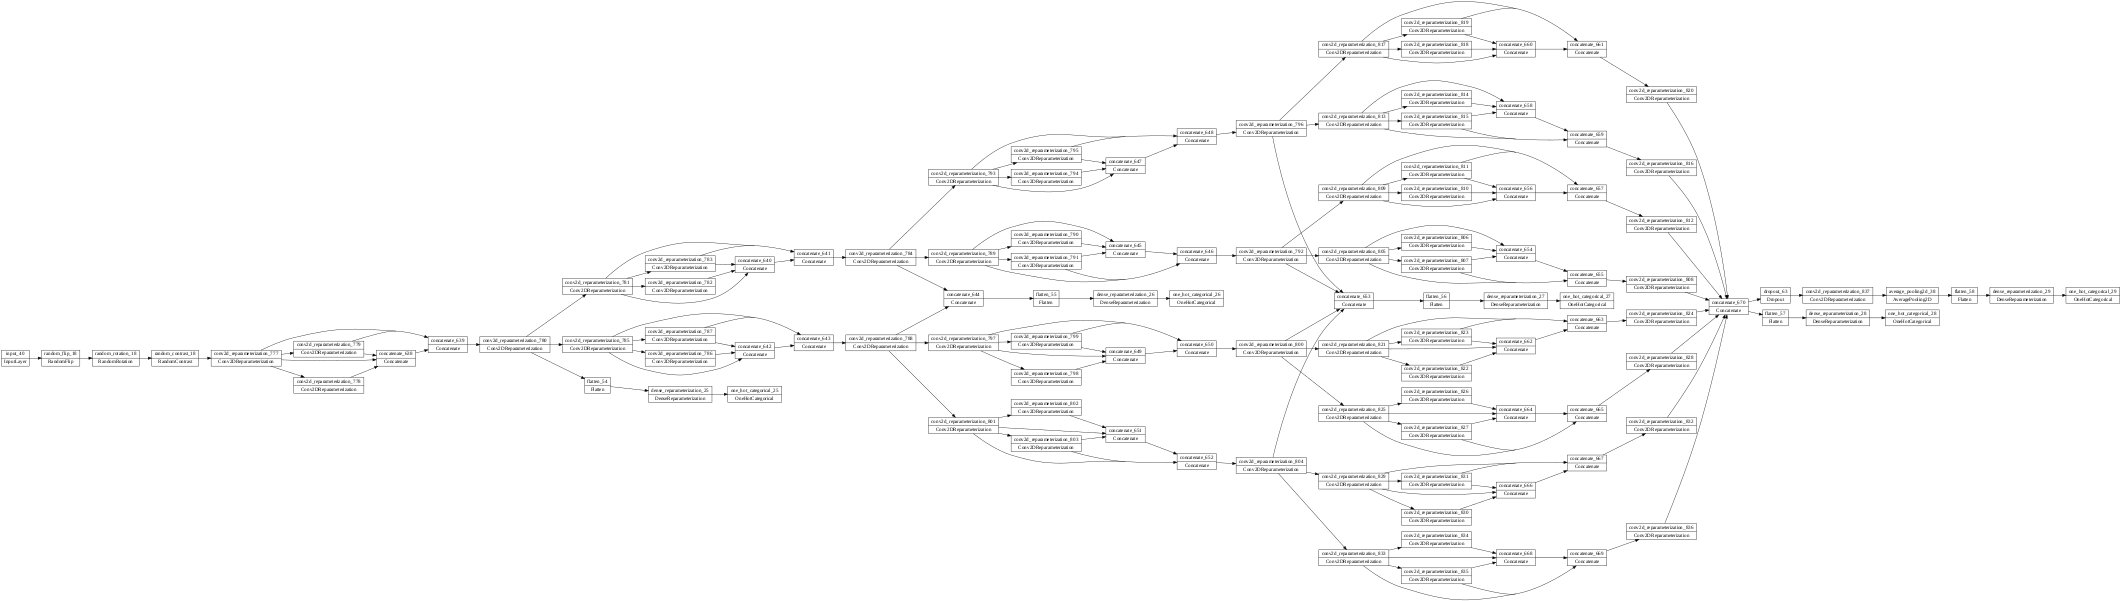

In [ ]:
plot_model(BI_DAG_Model,to_file='My_Model.png',rankdir='LR',dpi=25) 

In [ ]:
def negative_log_likelihood(y_true, y_pred):      # 'sparse_categorical_crossentropy'
    return -y_pred.log_prob(y_true)
BI_DAG_Model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005),loss=negative_log_likelihood,
                 metrics=['accuracy'])

In [ ]:
BI_DAG_Model.summary()
#    np.array(TRAINLABEL_FRAME[['0/Benign','1/Early','2/Pre','3/Pro']].values,dtype=np.float),


Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_40 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip_18 (RandomFlip)    (None, 128, 128, 3)  0           ['input_40[0][0]']               
                                                                                                  
 random_rotation_18 (RandomRota  (None, 128, 128, 3)  0          ['random_flip_18[0][0]']         
 tion)                                                                                            
                                                                                           

In [ ]:
hist=BI_DAG_Model.fit( tf.convert_to_tensor(x_train,dtype=tf.float32),
                      #  np.array(TRAINLABEL_FRAME['y_train'].values,dtype=np.float),
    [np.array(TRAINLABEL_FRAME[['0/Benign','1/Early','2/Pre','3/Pro']].values,dtype=np.float),
     np.array(TRAINLABEL_FRAME[['0/Benign','1/Early','2/Pre','3/Pro']].values,dtype=np.float),
     np.array(TRAINLABEL_FRAME[['0/Benign','1/Early','2/Pre','3/Pro']].values,dtype=np.float),
     np.array(TRAINLABEL_FRAME[['0/Benign','1/Early','2/Pre','3/Pro']].values,dtype=np.float),
     np.array(TRAINLABEL_FRAME[['0/Benign','1/Early','2/Pre','3/Pro']].values,dtype=np.float)],
   epochs=30,validation_split=0.15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.
/u

Epoch 1/30
67/67 [==============================] - 1804s 26s/step - loss: 1012.5826 - one_hot_categorical_25_loss: 1.4335 - one_hot_categorical_26_loss: 1.5091 - one_hot_categorical_27_loss: 3.9147 - one_hot_categorical_28_loss: 2.2110 - one_hot_categorical_29_loss: 3.0762 - one_hot_categorical_25_accuracy: 0.2489 - one_hot_categorical_26_accuracy: 0.2428 - one_hot_categorical_27_accuracy: 0.2480 - one_hot_categorical_28_accuracy: 0.2344 - one_hot_categorical_29_accuracy: 0.2593 - val_loss: 979.2582 - val_one_hot_categorical_25_loss: 1.3646 - val_one_hot_categorical_26_loss: 1.3771 - val_one_hot_categorical_27_loss: 1.3634 - val_one_hot_categorical_28_loss: 21.2748 - val_one_hot_categorical_29_loss: 1.8329 - val_one_hot_categorical_25_accuracy: 0.3013 - val_one_hot_categorical_26_accuracy: 0.2293 - val_one_hot_categorical_27_accuracy: 0.2693 - val_one_hot_categorical_28_accuracy: 0.2187 - val_one_hot_categorical_29_accuracy: 0.2907
Epoch 2/30
67/67 [==============================] - 1

In [ ]:
print(BI_DAG_Model.evaluate(tf.convert_to_tensor(x_test,dtype=tf.float32),
    tf.convert_to_tensor(TESTLABEL_FRAME[['0/Benign','1/Early','2/Pre','3/Pro']].values,dtype=tf.float32) 
                            ))
plt.rcParams['figure.figsize']=(15,5)
pd.DataFrame(hist.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
plt.plot(hist.history['loss'])

In [ ]:
preds=BI_DAG_Model.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.array(y_test,dtype=np.int64),np.round(preds).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.16      0.18      0.17       124
           1       0.31      0.28      0.30       239
           2       0.30      0.32      0.31       220
           3       0.22      0.21      0.21       173

    accuracy                           0.26       756
   macro avg       0.25      0.25      0.25       756
weighted avg       0.26      0.26      0.26       756



In [ ]:
BT_Model.save('')

## Simple Model

In [ ]:
INPUT=keras.layers.Input(shape=(128,128,3))
AUG_1=keras.layers.RandomFlip("horizontal_and_vertical")(INPUT)
AUG_2=keras.layers.RandomRotation(0.2)(AUG_1)
AUG_3=keras.layers.RandomContrast(0.2)(AUG_2)
CON_1=keras.layers.Conv2D(8,(3,3),activation='relu',padding='same')(AUG_3)
CON_2=keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(CON_1)
pool_1=keras.layers.AveragePooling2D((2,2))(CON_2)
BN_1=keras.layers.BatchNormalization()(pool_1)
Dropout_1=keras.layers.Dropout(0.3)(BN_1)
CON_3=keras.layers.Conv2D(8,(3,3),activation='relu',padding='same')(Dropout_1)
CON_4=keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(CON_3)
pool_2=keras.layers.AveragePooling2D((2,2))(CON_4)
BN_1=keras.layers.BatchNormalization()(pool_2)
Dropout_2=keras.layers.Dropout(0.3)(BN_1)
CON_5=keras.layers.Conv2D(8,(3,3),activation='relu',padding='same')(Dropout_2)
CON_6=keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(CON_5)
pool_3=keras.layers.AveragePooling2D((2,2))(CON_6)
CON_7=keras.layers.Conv2D(8,(3,3),activation='relu',padding='same')(pool_3)
CON_8=keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(CON_7)
pool_4=keras.layers.AveragePooling2D((2,2))(CON_6)

dense_1=keras.layers.Dense(16,activation='relu')(keras.layers.Flatten()(pool_4))
dense_2=keras.layers.Dense(16,activation='relu')(keras.layers.Flatten()(pool_3))
dense_3=keras.layers.Dense(16,activation='relu')(keras.layers.Flatten()(pool_2))
dense_4=keras.layers.Dense(16,activation='relu')(keras.layers.Flatten()(pool_1))
Hub=keras.layers.concatenate([dense_1,dense_2,dense_3,dense_4])
dense__=keras.layers.Dense(64,activation='relu')(Hub)
bn_1=keras.layers.BatchNormalization()(dense__)
drop_out=keras.layers.Dropout(0.3)(bn_1)
dense_=keras.layers.Dense(32,activation='relu')(drop_out)
output=keras.layers.Dense(4,activation='softmax')(dense_)
BT_Model=keras.models.Model([INPUT],[output])

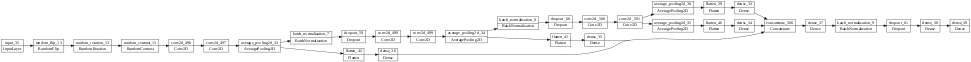

In [ ]:
plot_model(BT_Model,to_file='My_Model.png',rankdir='LR',dpi=20) # 

In [ ]:
BT_Model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip_13 (RandomFlip)    (None, 128, 128, 3)  0           ['input_35[0][0]']               
                                                                                                  
 random_rotation_13 (RandomRota  (None, 128, 128, 3)  0          ['random_flip_13[0][0]']         
 tion)                                                                                            
                                                                                           

In [ ]:
BT_Model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
hist=BT_Model.fit( tf.convert_to_tensor(x_train,dtype=tf.float32),
   tf.convert_to_tensor(TRAINLABEL_FRAME['y_train'].values,dtype=tf.float32),epochs=20,validation_split=0.15)

21/21 [==============================] - 5s 250ms/step - loss: 0.4258 - Accuracy: 0.8460
[0.4257813096046448, 0.8460366129875183]


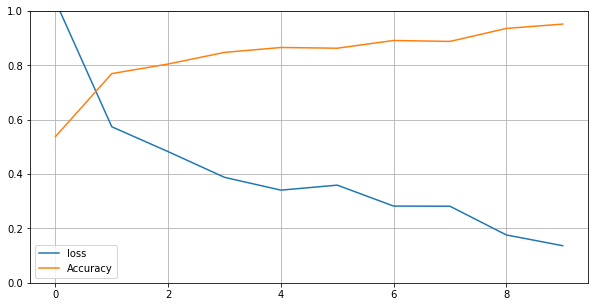

In [ ]:
print(BT_Model.evaluate(tf.convert_to_tensor(x_test,dtype=tf.float32),
                  tf.convert_to_tensor(y_test,dtype=tf.float32)))
pd.DataFrame(hist.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
preds=Model.predict(x_test)
print(classification_report(np.array(y_test,dtype=np.int64),np.round(preds).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.60      0.58      0.59       106
           1       0.83      0.81      0.82       189
           2       0.91      0.94      0.92       208
           3       0.98      0.99      0.99       153

    accuracy                           0.86       656
   macro avg       0.83      0.83      0.83       656
weighted avg       0.85      0.86      0.85       656



In [ ]:
# def PROBABILISTIC_CONV_LAYER(filters,size):
#   return keras.layers.Conv2D(filters,size,activation='relu',padding='same')
# INPUT=keras.layers.Input(shape=(128,128,3))
# Aumentation=Data_augmentation(INPUT)
# Res_Block_1=Hyper_Residuary_Bloc(Aumentation,8)
# Res_Block_2=Hyper_Residuary_Bloc(Res_Block_1,16)
# Res_Block_3=Hyper_Residuary_Bloc(Res_Block_2,16)
# Res_Block_4=Hyper_Residuary_Bloc(Res_Block_3,32)
# Res_Block_5=Hyper_Residuary_Bloc(Res_Block_4,32)
# Res_Block_6=Hyper_Residuary_Bloc(Res_Block_5,64)
# incp_3=Complex_Incept_Block(Res_Block_6,8,16,32)
# GP=keras.layers.GlobalAveragePooling2D()(incp_3)
# flat=keras.layers.Flatten()(GP)
# dense_1=keras.layers.Dense(64,activation='relu')(flat)
# output=keras.layers.Dense(4,activation='softmax')(dense_1)
# BI_DAG_Model=keras.models.Model([INPUT],[output])

# BI_DAG_Model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.05),loss='sparse_categorical_crossentropy',
#                  metrics=['accuracy'])
# hist=BI_DAG_Model.fit( tf.convert_to_tensor(x_train,dtype=tf.float32),
#    tf.convert_to_tensor(TRAINLABEL_FRAME['y_train'].values,dtype=tf.float32),
#    epochs=30)